# Hull-White Pricing using a Neural Network
Author: Joerg Kienitz (finciraptor.de, https://github.com/Lapsilago), Machine Learning for Option Pricing, Calibration and Hedging
Workshop with Nikolai Nowaczyk (https://github.com/niknow; https://github.com/niknow/machine-learning-examples)]

## Hull-White 1 Factor Model 

Hull-White model was one of the first practical exogenous models that attempted to fit to the market interest rate term structures. The model is described as:

\begin{equation}
dr_t = (\theta(t) - a r_t) dt + \sigma dW_t
\end{equation}

where $a$ is the mean reversion constant, $\sigma$ is the volatility parameter. The parameter $\theta(t)$ is chosen in order to fit the input term structure of interest rates. 

What is the "right" value for parameters $a$ and $\sigma$? This is the question that we address by calibrating to market instruments.

In [1]:
import QuantLib as ql
from collections import namedtuple
import math

In [2]:
today = ql.Date(15, ql.November, 2019);
settlement= ql.Date(19, ql.November, 2019);
ql.Settings.instance().evaluationDate = today;
sr = 0.003
term_structure = ql.YieldTermStructureHandle(
    ql.FlatForward(settlement,sr,ql.Actual365Fixed())
    )
index = ql.Euribor1Y(term_structure)

In this example we are going to calibrate to the swaption volatilities as shown below. 

In [3]:
CalibrationData = namedtuple("CalibrationData", 
                             "start, length, volatility")
data = [CalibrationData(1, 5, 0.1148),
        CalibrationData(2, 4, 0.1108),
        CalibrationData(3, 3, 0.1070),
        CalibrationData(4, 2, 0.1021),
        CalibrationData(5, 1, 0.1000 ),
        CalibrationData(1, 9, 0.1108),
        CalibrationData(2, 8, 0.1070),
        CalibrationData(3, 7, 0.1021),
        CalibrationData(4, 6, 0.1000 ),
        CalibrationData(5, 5, 0.1108),
        CalibrationData(6, 4, 0.1070),
        CalibrationData(7, 3, 0.1021),
        CalibrationData(8, 2, 0.09 ),
        CalibrationData(9, 1, 0.08)]

In [4]:
# <!-- collapse=True -->
def create_swaption_helpers(data, index, term_structure, engine):
    swaptions = []
    fixed_leg_tenor = ql.Period(1, ql.Years)
    fixed_leg_daycounter = ql.Actual360()
    floating_leg_daycounter = ql.Actual360()
    for d in data:
        vol_handle = ql.QuoteHandle(ql.SimpleQuote(d.volatility))
        helper = ql.SwaptionHelper(ql.Period(d.start, ql.Years),
                                   ql.Period(d.length, ql.Years),
                                   vol_handle,
                                   index,
                                   fixed_leg_tenor,
                                   fixed_leg_daycounter,
                                   floating_leg_daycounter,
                                   term_structure
                                   )
        helper.setPricingEngine(engine)
        swaptions.append(helper)
    return swaptions    


In [5]:
a = 0.07
sigma = 0.02
model = ql.HullWhite(term_structure,a, sigma);
engine = ql.JamshidianSwaptionEngine(model)
swaptions = create_swaption_helpers(data, index, term_structure, engine)

a, sigma = model.params()
print("a = %6.5f, sigma = %6.5f" % (a, sigma))

ff = [s.modelValue() for (i,s) in enumerate(swaptions)]
ff
#for i, s in enumerate(swaptions):
#        st = type(s)
#        model_price = s.modelValue()
#        print(model_price, st)

a = 0.07000, sigma = 0.02000


[0.03227408357309807,
 0.036413414605577024,
 0.03346070890936483,
 0.025808499585154993,
 0.014393684840156164,
 0.05078155362927418,
 0.06351608406917204,
 0.06793437584192456,
 0.06710618247636566,
 0.062489223930518964,
 0.05483102886775399,
 0.044517323869753496,
 0.03185709910128186,
 0.016963251738110644]

In [21]:
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# create model parameters and prices
NTrain = 100000
Nparams = 3
u01 = np.random.rand(NTrain,Nparams)

Smin = 0.0; Smax = 0.1; Sdelta = Smax-Smin;
kappamin = 0.00001; kappamax = 0.05; kappadelta = kappamax - kappamin;
Vmin = 0.0001; Vmax = 0.2; Vdelta = Vmax - Vmin; 

lb=[Smin,kappamin, Vmin]
ub=[Smax,kappamax, Vmax]

Vecdelta = [Sdelta, kappadelta, Vdelta]

xx =  lb + Vecdelta * u01

yy = np.zeros((NTrain, 14))

# this is for generating the prices
for i in range(0,NTrain):
    term_structure = ql.YieldTermStructureHandle(ql.FlatForward(settlement,xx[i][0],ql.Actual365Fixed()))
    model = ql.HullWhite(term_structure,xx[i][1], xx[i][2]);
    engine = ql.JamshidianSwaptionEngine(model)
    swaptions = create_swaption_helpers(data, index, term_structure, engine)
    mval = [s.modelValue() for (i,s) in enumerate(swaptions)]
    yy[i][:] = mval
    
print(xx.shape)
print(yy.shape)


(100000, 3)
(100000, 14)


In [15]:
# save the generated prices for using them in the future without calculation
#np.savetxt("xx.txt", xx)
#np.savetxt("yy.txt", yy)
#np.savetxt("Vecmin.txt", Vecmin)
#np.savetxt("Vecdelta.txt", Vecdelta)

In [16]:
# import already calculated prices
#import os
#xx = np.loadtxt('xx.txt')     # train on implied volatilities
#yy = np.loadtxt('yy.txt')


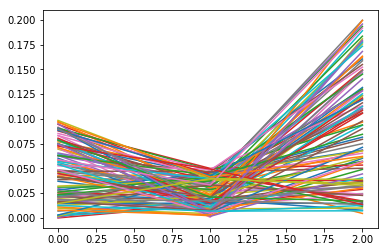

In [22]:
# plot some results for a fixed maturity
offset = 0
j = 1
for i in range(100):
    plt.plot(xx[offset + i,(j-1)*14:(j)*14])

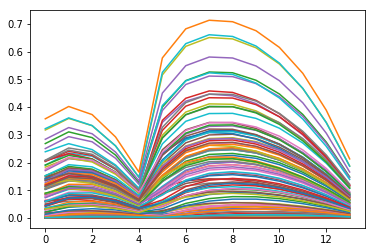

In [23]:
# plot some parameter sets
offset = 0
j = 1
for i in range(100):
    plt.plot(yy[offset + i,:])

### Training a Neural Net to Learn Hull-White Pricing


In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)                # test_size is the percentage used for validation/test

In [25]:
# define the neural network
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


keras.backend.set_floatx('float64')
input1 = keras.layers.Input(shape=(Nparams,))                    # input layer

x1 = keras.layers.Dense(10,activation = 'elu')(input1)             # hidden layer 1
x2 = keras.layers.Dense(10,activation = 'elu')(x1)                 # hidden layer 2
x3 = keras.layers.Dense(10,activation = 'elu')(x2)                 # hidden layer 3

x4=keras.layers.Dense(14,activation = 'linear')(x3)                # output layer; size depends on option surface
#x4=keras.layers.Dense(121,activation = 'linear')(x3)

# set up the model
modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()


# this is just for testing, the best results are currently obtained with 30 for the dense layers!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 14)                154       
Total params: 414
Trainable params: 414
Non-trainable params: 0
_________________________________________________________________


In [27]:
# define the objective function and do the compilation and fitting

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")

Nepoch = 5 #better 50 or larger 
# fit/calibrate the model using defined loss function

# the model takes y_train_transform as input (the model smile)
# and it learns the model parameters, the output or predictions
#history = modelGEN.fit(y_train_transform, x_train_transform, batch_size=32,validation_data = (y_test_transform,x_test_transform),epochs = 200, verbose = True,shuffle=1)#,callbacks=[earlystop])
history = modelGEN.fit(x_train, y_train, batch_size=32,validation_data = (x_test,y_test),epochs = Nepoch, verbose = True,shuffle=1)

Train on 85000 samples, validate on 15000 samples
Epoch 1/5
85000/85000 [==============================] - 10s 122us/step - loss: 0.0075 - val_loss: 0.0072
Epoch 2/5
85000/85000 [==============================] - 10s 121us/step - loss: 0.0073 - val_loss: 0.0070
Epoch 3/5
85000/85000 [==============================] - 10s 118us/step - loss: 0.0069 - val_loss: 0.0066
Epoch 4/5
85000/85000 [==============================] - 10s 119us/step - loss: 0.0065 - val_loss: 0.0062
Epoch 5/5
85000/85000 [==============================] - 10s 118us/step - loss: 0.0058 - val_loss: 0.0061


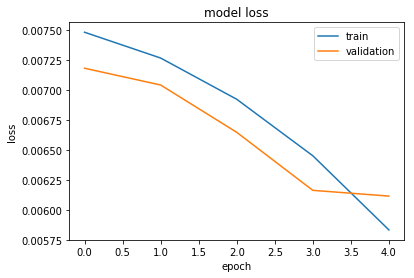

In [28]:
# summarize history for loss and plot on training and validation set
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Index %i 0
Index %i 1
Index %i 2
Index %i 3
Index %i 4
Index %i 5
Index %i 6
Index %i 7
Index %i 8
Index %i 9
Index %i 10
Index %i 11
Index %i 12
Index %i 13
Index %i 14
Index %i 15
Index %i 16
Index %i 17
Index %i 18
Index %i 19
Index %i 20
Index %i 21
Index %i 22
Index %i 23
Index %i 24
Index %i 25
Index %i 26
Index %i 27
Index %i 28
Index %i 29
Index %i 30
Index %i 31
Index %i 32
Index %i 33
Index %i 34
Index %i 35
Index %i 36
Index %i 37
Index %i 38
Index %i 39
Index %i 40
Index %i 41
Index %i 42
Index %i 43
Index %i 44
Index %i 45
Index %i 46
Index %i 47
Index %i 48
Index %i 49
Index %i 50
Index %i 51
Index %i 52
Index %i 53
Index %i 54
Index %i 55
Index %i 56
Index %i 57
Index %i 58
Index %i 59
Index %i 60
Index %i 61
Index %i 62
Index %i 63
Index %i 64
Index %i 65
Index %i 66
Index %i 67
Index %i 68
Index %i 69
Index %i 70
Index %i 71
Index %i 72
Index %i 73
Index %i 74
Index %i 75
Index %i 76
Index %i 77
Index %i 78
Index %i 79
Index %i 80
Index %i 81
Index %i 82
Index %i 83
In

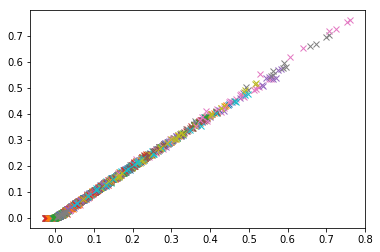

In [29]:
Nt = 100
u = np.random.rand(Nt,3)
x_t = lb + Vecdelta * u

error = []
err_m = 0; index_err_m = -100
n = 0
for j in range(0,Nt):
    term_structure = ql.YieldTermStructureHandle(
        ql.FlatForward(settlement,x_t[j][0],ql.Actual365Fixed()))
    model = ql.HullWhite(term_structure, x_t[j][1], x_t[j][2]);
    engine = ql.JamshidianSwaptionEngine(model)
    swaptions = create_swaption_helpers(data, index, term_structure, engine)
    y_nn = modelGEN.predict(x_t[j].reshape(1,Nparams))[0]
    y_ql = [s.modelValue() for (i,s) in enumerate(swaptions)]
    error_loc = np.mean(np.abs(y_nn-y_ql))
    if np.abs(error_loc) > err_m:
        index_err_m = j
        err_m = error_loc
    error.append(error_loc)
    if error_loc > 0.0001:
        print('Index %i', j)
        n = n+1
    plt.plot(y_nn,y_ql,'x')

max pricing error: 154.74570075027617
average pricing error: 38.60927619847306
error bigger than 0.0001: 100
max error occurs at index 59


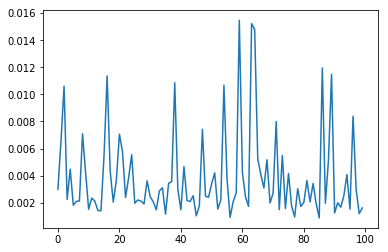

In [30]:
plt.plot(error)
print('max pricing error:',np.max(np.abs(error))*10000)
print('average pricing error:', np.mean(np.abs(error))*10000)
print('error bigger than 0.0001:', n)
print('max error occurs at index', index_err_m)

-0.0023871709042390167

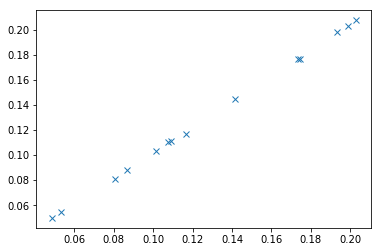

In [31]:
j = 94
term_structure = ql.YieldTermStructureHandle(
ql.FlatForward(settlement,x_train[j][0],ql.Actual365Fixed()))
model = ql.HullWhite(term_structure, x_train[j][1], x_train[j][2]);
engine = ql.JamshidianSwaptionEngine(model)
swaptions = create_swaption_helpers(data, index, term_structure, engine)
y_nn = modelGEN.predict(x_train[j].reshape(1,Nparams))[0]
y_ql = [s.modelValue() for (i,s) in enumerate(swaptions)]
plt.plot(y_nn,y_ql,'x')
np.mean(y_nn-y_ql)

In [32]:
np.corrcoef(y_nn, y_ql)[0,1]

0.999863280909044

In [33]:
x_t[j]

array([0.08322631, 0.001452  , 0.09662033])